<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

______________________________________________________________________

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [ ]:
!pip install --upgrade pip

In [ ]:
# Option - I: Uncomment the next line if you want to install via pip.
%pip install anomalib

### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [ ]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

In [ ]:
!which python

In [ ]:
# !pip install -r '/home/hajer/dev/anomalib/requirements/openvino.txt'
# !pip install -r '/home/hajer/dev/anomalib/requirements/openvino.txt'

### Install Picsellia package

In [ ]:
!pip install picsellia

 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.

In [1]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

# from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
# else:
#     # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
#     repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
#     root_directory = current_directory / "anomalib"

os.chdir(root_directory)

In [ ]:
# root_directory = str(root_directory)

In [ ]:
!pip install urllib3==1.26.6

## Imports

In [2]:
import yaml
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from picsellia import Client
from picsellia.types.enums import LogType
from picsellia.exceptions import ResourceNotFoundError


To use wandb logger install it using `pip install wandb`


### Connect to Picsellia and get experiment


In [3]:
api_token = ""
client = Client(api_token=api_token, organization_name="hajer")
experiment_id = "01886eb4-2a0e-71b8-9320-760913395ac7"
experiment = client.get_experiment_by_id(experiment_id)


Hi pierre-nicolas, welcome back. 🥑
Workspace: hajer's organization.


## Configuration


In [4]:
MODEL = "patchcore"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'

### Get the dataset from Picsellia

In [5]:
for dataset_type in ['good', 'abnormal', 'mask']:
    assets = experiment.get_dataset(dataset_type)
    assets.download(os.path.join(root_directory, experiment.png_dir, dataset_type))

100%|███████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 51.18it/s]

0 assets downloaded (over 34) in directory /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/good
Assets of Version 'good' of dataset hazelnut  (id: 018866d9-e24a-7d22-93d7-81230a11223c) downloaded into /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/good



100%|███████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 62.62it/s]

0 assets downloaded (over 17) in directory /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/abnormal
Assets of Version 'abnormal' of dataset hazelnut  (id: 018866d8-b94d-71a3-80ce-c32571658d6d) downloaded into /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/abnormal



100%|███████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 45.14it/s]

0 assets downloaded (over 17) in directory /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/mask
Assets of Version 'mask' of dataset hazelnut  (id: 018866dc-928b-77e8-9459-50aa772f624e) downloaded into /Users/pierre-nicolastiffreau/picsellia-anomalib/test-pn/images/mask


### Write to Config File

In [6]:
from picsellia.exceptions import ResourceNotFoundError
try:
    config = experiment.get_artifact('config')
    config.download(experiment.config_dir)
    config_fullpath = os.path.join(experiment.config_dir, config.filename)
except ResourceNotFoundError:
    config_fullpath = os.path.join(root_directory, "src", "anomalib", "models", "patchcore", "config.yaml")
config_data = yaml.safe_load(open(config_fullpath, 'r'))

In [7]:
# get experiment's parameters
try:
    parameters = experiment.get_log(name='parameters').data
except ResourceNotFoundError:
    parameters = {}
batch_size = parameters.get("batch_size", 16)
max_epochs = parameters.get("max_epochs", 50)

In [8]:
dataset_name = experiment.get_dataset(name='good').name
config_data['dataset']['name'] = dataset_name
config_data['dataset']['format'] = 'folder'
config_data['dataset']['root'] = os.path.join(root_directory, experiment.png_dir)
config_data['dataset']['path'] = os.path.join(root_directory, experiment.png_dir)
config_data['dataset']['normal_dir'] = 'good'
# config_data['dataset']['normal_test_dir'] = None

config_data['dataset']['abnormal_dir'] = 'abnormal'
config_data['dataset']['mask_dir'] = 'mask'
config_data['dataset']['task'] = 'segmentation'
config_data['dataset']['train_batch_size'] = batch_size
config_data['dataset']['extensions'] = None
config_data['trainer']['max_epochs'] = max_epochs

config_data['project']['path'] = os.path.join(root_directory, experiment.results_dir)

config_data['model']['name'] = MODEL


In [9]:
with open(config_fullpath, 'w') as cfg:
    cfg.write( yaml.dump(config_data, default_flow_style=False))

In [10]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=config_fullpath)

/Users/pierre-nicolastiffreau/picsellia-anomalib/src/anomalib/config/config.py:238: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/Users/pierre-nicolastiffreau/picsellia-anomalib/src/anomalib/config/config.py:275: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [11]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))

Let's check the shapes of the input images and masks.

In [56]:
print(data["image"].shape, data["mask"].shape)

torch.Size([23, 3, 224, 224]) torch.Size([23, 224, 224])


We could now visualize a normal and abnormal sample from the validation set.

/Users/pierre-nicolastiffreau/picsellia-anomalib/src/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


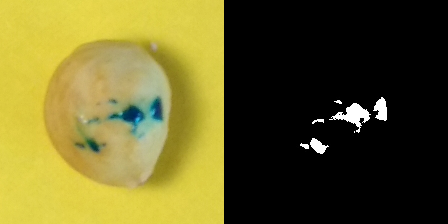

In [12]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [13]:
 # Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"
# config.optimization.export_mode = "onnx"

try:
    checkpoint_file = experiment.get_artifact('checkpoints')
    loaded_checkpoint_path = os.path.join(root_directory, experiment.checkpoint_dir)
    checkpoint_file.download(loaded_checkpoint_path)
except ResourceNotFoundError as e:
    loaded_checkpoint_path = None
    model = get_model(config)
# Get the model and callbacks

callbacks = get_callbacks(config)

/Users/pierre-nicolastiffreau/.virtualenvs/picsellia-anomalib/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
from pytorch_lightning import Callback

class SaveTrainingMetrics(Callback):

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        experiment.log(name='training_pixel_F1score', type=LogType.LINE,data= float(trainer.callback_metrics['pixel_F1Score']))
        experiment.log(name='training_pixel_AUROC', type=LogType.LINE,data= float(trainer.callback_metrics['pixel_AUROC']))
        experiment.log(name='training_image_F1Score', type=LogType.LINE,data= float(trainer.callback_metrics['image_F1Score']))
        experiment.log(name='training_image_AUROC', type=LogType.LINE,data= float(trainer.callback_metrics['image_AUROC']))

In [15]:
callbacks.insert(len(callbacks),SaveTrainingMetrics())

In [16]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)

/Users/pierre-nicolastiffreau/.virtualenvs/picsellia-anomalib/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [ ]:
# load_model_callback = LoadModelCallback(weights_path=os.path.join(loaded_checkpoint_path, checkpoint_file.filename))
# load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
# trainer.callbacks.insert(0, load_model_callback)

In [17]:
trainer.fit(model=model, datamodule=datamodule)

/Users/pierre-nicolastiffreau/.virtualenvs/picsellia-anomalib/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/Users/pierre-nicolastiffreau/.virtualenvs/picsellia-anomalib/lib/python3.9/site-packages/pytorch_lightning/core/optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(
/Users/pierre-nicolastiffreau/.virtualenvs/picsellia-anomalib/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
# trainer.fit(model=model, datamodule=datamodule)

## Validation

In [ ]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
# load_model_callback = LoadModelCallback(weights_path=os.path.join(loaded_checkpoint_path, checkpoint_file.filename))
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

In [ ]:
trainer.checkpoint_callback.best_model_path

### Log test results to Picsellia

In [ ]:
experiment.log(name="test_results", type=LogType.TABLE, data=test_results[0])

### Log best model's checkpoints to Picsellia

In [ ]:
experiment.store('best_model_checkpoints', trainer.checkpoint_callback.best_model_path)

### Log openvino and onnx models

In [ ]:
model_root = os.path.join(root_directory, experiment.results_dir, MODEL, dataset_name,'run/weights/openvino/')
experiment.store('openvino_metadata', os.path.join(model_root,'metadata.json'))
experiment.store('openvino_bin', os.path.join(model_root,'metadata.json'))
experiment.store('model_onnx', os.path.join(model_root,'model.onnx'))

In [ ]:
experiment.list_artifacts()

In [ ]:
experiment.log(os.path.join(model_root, ))

In [ ]:
trainer.checkpoint_callback.best_model_path

## OpenVINO Inference
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.

In [ ]:
# image_path = root_directory / "datasets/MVTec/bottle/test/broken_large/000.png"
# image = read_image(path="./datasets/MVTec/bottle/test/broken_large/000.png")

# /home/hajer/dev/anomalib/datasets/hazelnut_toy/colour/03.jpg
image_path = root_directory / "datasets/hazelnut_toy/colour/03.jpg"
image = read_image(path=image_path)
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [ ]:
output_path = Path(config["project"]["path"])
print(output_path)

In [ ]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"

print(openvino_model_path.exists(), metadata.exists())

In [ ]:
# model_path = "/home/hajer/dev/anomalib/results/patchcore/hazelnut/run/weights/lightning/model.ckpt"

In [ ]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

In [ ]:
print(image.shape)

In [ ]:
predictions = inferencer.predict(image=image)

where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

In [ ]:
print(predictions.pred_score, predictions.pred_label)

In [ ]:
# Visualize the original image
plt.imshow(predictions.image)

In [ ]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

In [ ]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

In [ ]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

In [ ]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.